In [1]:
# install required packages
!pip install konlpy

# clear install verbose messages
from IPython.display import clear_output
clear_output()

import urllib.request
import zipfile
from lxml import etree
import re
import tqdm

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')

import gensim
from gensim.models import KeyedVectors, Word2Vec

import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import konlpy
from konlpy.tag import Okt
# from gensim.models.word2vec import Word2Vec


def show_table(df, sample_num=2):
  print('>>> shape :', df.shape)
  print('>>> No of NA :', df.isna().sum().sum())
  if len(df) <= sample_num*2:
    display(df)
  else:
    display(df.head(sample_num))
    display(df.tail(sample_num))
  pass


# nltk : 3.2.5  |  gensim : 3.6.0
print(f'\n>>> nltk : {nltk.__version__}  |  gensim : {gensim.__version__}  |  pd : {pd.__version__}  |  konlpy : {konlpy.__version__}') 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

>>> nltk : 3.2.5  |  gensim : 3.6.0  |  pd : 1.1.5  |  konlpy : 0.5.2


## 1. 영어 Word2Vec 만들기 (Word2Vec in English)

In [2]:
%%time

# donwload corpus
urllib.request.urlretrieve("https://raw.githubusercontent.com/GaoleMeng/RNN-and-FFNN-textClassification/master/ted_en-20160408.xml", filename="ted_en-20160408.xml")

# get text data from corpus
with open('ted_en-20160408.xml') as fp:
  target_text = etree.parse(fp)
text_list = target_text.xpath('//content/text()')

# check text data
print(len(text_list), 'texts \n')
for idx, line in enumerate(text_list[:5]):
  print(f'>>> Line {idx}. {line[:500]}...\n')

2085 texts 

>>> Line 0. Here are two reasons companies fail: they only do more of the same, or they only do what's new.
To me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation. Both are necessary, but it can be too much of a good thing.
Consider Facit. I'm actually old enough to remember them. Facit was a fantastic company. They were born deep in the Swedish forest, and they made the best mechanical calculators in the world. Everybody used them. A...

>>> Line 1. So there are lands few and far between on Earth itself that are hospitable to humans by any measure, but survive we have. Our primitive ancestors, when they found their homes and livelihood endangered, they dared to make their way into unfamiliar territories in search of better opportunities. And as the descendants of these explorers, we have their nomadic blood coursing through our own veins. But at the same time, distracted by our bread and circuses an

In [3]:
%%time

# pre-process text data
parse_text = '\n'.join(text_list)
content_text = re.sub(r'\([^)]*\)', '', parse_text)  # (Audio), (Laughter) 등의 배경음 제거 - 괄호로 구성된 내용 제거
sent_text = sent_tokenize(content_text)  # 문장 토큰화

result = []
for sentence in tqdm.tqdm_notebook(sent_text):
  sentence = re.sub(r"[^a-z0-9]+", " ", sentence)  # 구두점 제거
  tokens = word_tokenize(sentence.lower())  # 단어 토큰화
  result.append(tokens)

print(len(result), result[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



273424 ['ere', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
CPU times: user 48.5 s, sys: 762 ms, total: 49.3 s
Wall time: 49.5 s


In [4]:
%%time
# train Word2Vec model
model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4, sg=0)

# check model
display(model.wv.most_similar('man'))

[('woman', 0.8899336457252502),
 ('guy', 0.8076452016830444),
 ('lady', 0.8012735843658447),
 ('girl', 0.7669002413749695),
 ('soldier', 0.7586746215820312),
 ('boy', 0.7400370836257935),
 ('gentleman', 0.7280025482177734),
 ('kid', 0.690168023109436),
 ('photographer', 0.6577188372612),
 ('person', 0.6439493894577026)]

CPU times: user 58.5 s, sys: 346 ms, total: 58.9 s
Wall time: 34 s


In [5]:
%%time
# save & load trained model
model.wv.save_word2vec_format(fname='eng_w2v')
loaded_model = KeyedVectors.load_word2vec_format(fname='eng_w2v')

# check loaded model
display(loaded_model.wv.most_similar('man'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


[('woman', 0.8899336457252502),
 ('guy', 0.8076452016830444),
 ('lady', 0.8012735843658447),
 ('girl', 0.7669002413749695),
 ('soldier', 0.7586746215820312),
 ('boy', 0.7400370836257935),
 ('gentleman', 0.7280025482177734),
 ('kid', 0.690168023109436),
 ('photographer', 0.6577188372612),
 ('person', 0.6439493894577026)]

CPU times: user 4.22 s, sys: 197 ms, total: 4.42 s
Wall time: 4.24 s


## 2. 한국어 Word2Vec 만들기 - 네이버 영화 리뷰 (Word2Vec with Naver Movie Reviews)

In [6]:
%%time

# download Korean corpus - Naver movie review
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

# load data
train_data = pd.read_table('ratings.txt')
train_data = train_data.dropna()  # drop rows with NA

# pre-process data - takes time
train_data['document_processed'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()
train_data['document_processed'] = train_data['document_processed'].apply(lambda sent : [tk for tk in okt.morphs(sent, stem=True) if tk not in stopwords])

# check the result
show_table(train_data)

>>> shape : (199992, 4)
>>> No of NA : 0


,id,document,label,document_processed
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1,"[어리다, 때, 보고, 지금, 다시, 보다, 재밌다, ㅋㅋ]"
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1,"[디자인, 을, 배우다, 학생, 외국, 디자이너, 그, 일군, 전통, 을, 통해, ..."


,id,document,label,document_processed
199998,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0,"[왜, 난, 재미없다, ㅠㅠ, 라따뚜이, 보다, 스머프, 보다, 그, 런가, ㅋㅋ]"
199999,8548411,포풍저그가나가신다영차영차영차,0,"[포, 풍, 저그, 나가다, 영차, 영차, 영차]"


CPU times: user 13min 40s, sys: 4.35 s, total: 13min 44s
Wall time: 13min 17s


>>> max  sentence length : 72
>>> mean sentence length : 10.716703668146726


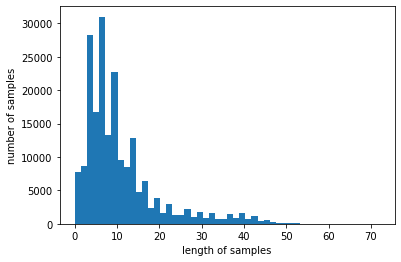

In [7]:
# check the distribution of sentence length
len_ser = train_data['document_processed'].str.len()
print('>>> max  sentence length :', len_ser.max())
print('>>> mean sentence length :', len_ser.mean())

len_ser.plot.hist(bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()